In [51]:
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import numpy as np

#crop settings
relXMin = 0.159
relXMax = 0.17
relYMin = 0.28
relYMax = 0.3
def rescaleArray(upper, outputArray, minVal, maxVal):
    clippedArray = np.clip(outputArray, minVal, upper)
    clippedRange = upper - minVal
    return (clippedArray - minVal) * 255 / clippedRange

In [52]:
with rasterio.open('data/rawPopulation.tif') as raw:
    popCrs = raw.crs
    popTransform = raw.transform
    array = raw.read(1)

In [53]:
#crop dimensions
XMin = np.floor(array.shape[1]*relXMin).astype(int)
XMax = np.floor(array.shape[1]*relXMax).astype(int)
YMin = np.floor(array.shape[0]*relYMin).astype(int)
YMax = np.floor(array.shape[0]*relYMax).astype(int)

cropHeight, cropWidth = YMax-YMin, XMax-XMin

croppedArray = array[YMin:YMax, XMin:XMax]

with rasterio.open('data/rawPopulation.tif') as raw:    
    cropWindow = Window(XMin, YMin, width = cropWidth, height = cropHeight)
    cropPopTransform = raw.window_transform(cropWindow)


Now I will do a convolution to access the area around a position in order to get a more accurate estimate for a good transit line routing.

In [54]:
filter = np.array([[1,2,1],
                   [2,4,2],
                   [1,2,1]])/16
convolvedArray = convolve2d(croppedArray, filter, mode = 'same', boundary = 'symm')
outputArray = convolvedArray

0 15343.171630859375


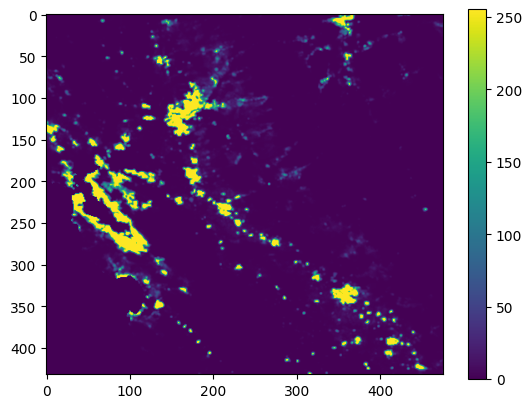

In [55]:
bandMin = 0 #np.min(convolvedArray)
bandMax = np.max(convolvedArray)
print(bandMin, bandMax)
#exportRawArray = rescaleArray(100, croppedArray, bandMin, bandMax)
exportConvolvedArray = rescaleArray(1000, convolvedArray, bandMin, bandMax)
plt.imshow(exportConvolvedArray)
plt.colorbar()

In [56]:
popDtype = exportConvolvedArray.dtype

In [57]:
with rasterio.open(
    'data/convolvedPopulation.tif', 'w',
    driver = 'GTiff',
    height = cropHeight,
    width = cropWidth,
    count = 1,
    crs = popCrs,
    transform = cropPopTransform,
    dtype = popDtype
) as conv:
    conv.write(exportConvolvedArray,1)